![Screenshot 2024-12-30 141304.png](<attachment:Screenshot 2024-12-30 141304.png>)
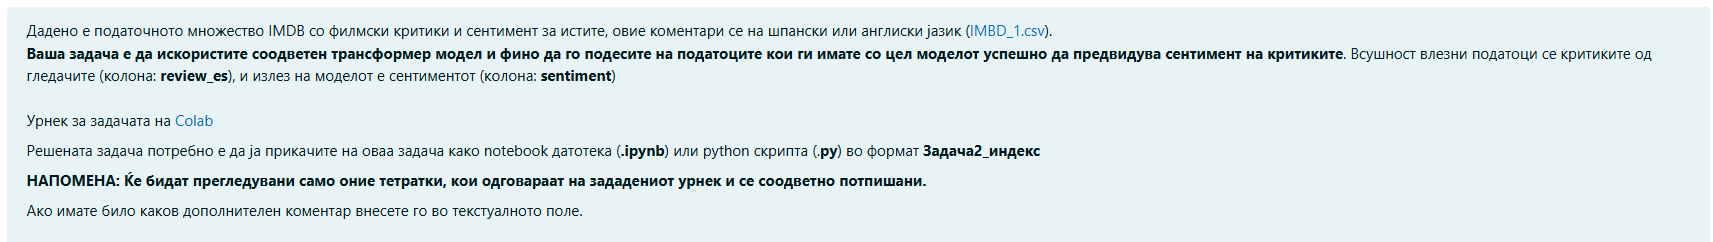

In [1]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files="data/IMDB_1.csv")
dataset

DatasetDict({
    train: Dataset({
        features: ['review_es', 'sentiment'],
        num_rows: 250
    })
})

In [2]:
df = dataset["train"].to_pandas()
df["sentiment"].unique()

array(['positive', 'negative'], dtype=object)

In [3]:
df

,review_es,sentiment
0,Uno de los otros críticos ha mencionado que de...,positive
1,Una pequeña pequeña producción.La técnica de f...,positive
2,Pensé que esta era una manera maravillosa de p...,positive
3,"Básicamente, hay una familia donde un niño peq...",negative
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positive
...,...,...
245,He visto esta película al menos 100 veces y to...,positive
246,Este espectáculo no tiene absolutamente ningún...,negative
247,¡Esta película fue tan mala que fue divertido!...,negative
248,"Meryl Streep es un genio.Bueno, al menos como ...",positive


# <font color='orange'>Направете претпроцесирање на податоците</font>

In [4]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

labels = encoder.fit_transform(dataset["train"]["sentiment"])

In [5]:
dataset["train"] = dataset["train"].add_column("label", labels)
dataset["train"] = dataset["train"].remove_columns("sentiment")
dataset = dataset.rename_column("review_es", "text")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

# <font color='orange'>Поделето го на тренирачко и тестирачко множество во сооднос 80:20</font>

In [6]:
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

# <font color='orange'>Искористете соодветен трансформер модел за проблемот</font>

In [7]:
dataset["train"].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [8]:
from transformers import AutoTokenizer

checkpoint = "google-bert/bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [9]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [10]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50
    })
})

# <font color='orange'>Фино-подесете (тренирајте) го моделот</font>

In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=8,  # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    metric_for_best_model="f1",
    num_train_epochs=3,
)

In [14]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [17]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [18]:
import torch

In [19]:
torch.cuda.is_available()

True

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
device

'cuda'

In [22]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.689852,0.540800
2,No log,0.689472,0.582540
3,No log,0.684181,0.555495


TrainOutput(global_step=75, training_loss=0.6958182779947917, metrics={'train_runtime': 344.6619, 'train_samples_per_second': 1.741, 'train_steps_per_second': 0.218, 'total_flos': 153759634086240.0, 'train_loss': 0.6958182779947917, 'epoch': 3.0})

In [24]:
trainer.evaluate()

{'eval_loss': 0.684181272983551,
 'eval_f1': 0.5554946727549467,
 'eval_runtime': 1.3712,
 'eval_samples_per_second': 36.463,
 'eval_steps_per_second': 5.105,
 'epoch': 3.0}

# <font color='orange'>Тестирајте го моделот на тестирачкото множество</font>

In [25]:
predictions = trainer.predict(tokenized_dataset["test"])

In [26]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

# <font color='orange'>Пресметајте f1 score</font>

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71        34
           1       0.27      0.19      0.22        16

    accuracy                           0.58        50
   macro avg       0.47      0.48      0.47        50
weighted avg       0.54      0.58      0.56        50



Text(0.5, 1.0, 'Confusion Matrix')

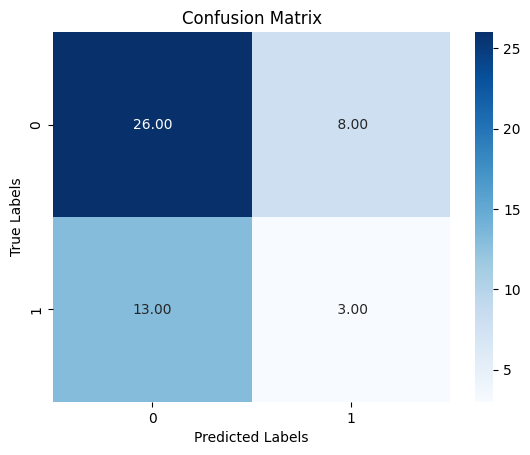

In [29]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")